**UNI:** am6490, cj2831, hk3354

**Full name:** Arsh Misra, Conor Jones, Flora Kwon

**Link to Public Github repository with Final report:**
https://github.com/hyerhinkwon/QMSS5074-Adv-ML.git

In [3]:
# Load libraries

import sys
import time
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.applications import ResNet50, InceptionV3

## 0. Loading Dataset

In [5]:
# Import data

import os
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip

## 1. Dataset and Exploratory Data Analysis

*Start by describing the dataset. Include basic statistics and image samples to show the types of images available (e.g., COVID-positive and negative chest x-rays).*

*Check if the dataset is balanced across classes. If it's imbalanced:*
*   *Discuss potential strategies such as class weighting, oversampling, undersampling, or augmentation.*
*   *Indicate which method you chose, and discuss how model performance changed as a result.*

*Reflect on the practical value of this classification task. Who might benefit from your model in a real-world setting?*

In [7]:
# Extracting all filenames iteratively
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# Load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [3616, 10192, 1345]


The original data consists chest X-ray images, 3616 images each for COVID-19 pneumonia, 1345 for viral pneumonia, and 10192 for normal.

To address class imbalance, we can utilize:
1. Class weighting: Assign higher weights to minority classes during training
2. Oversampling: Create synthetic samples of minority classes (e.g., SMOTE)
3. Undersampling: Remove samples from majority classes
4. Data augmentation: Generate additional samples through transformations

For our approach, we decided to artificially balance the dataset (by preserving 1344 samples per class), same as the source paper. This means that all classes will contirubte equally to gradien updates and prevent model bias towards the larger viral pneumonia class and normal cllass. In the paper, this demonstrated improved test accuracy and balanced performance across classes for confusion matrices.

From this classification exercise, we can provide insights to aid healthcare professionals in interpretting radiology reports and provide diagnostic support. From general ML knowledge perspective, it will also improve pattern recognition and its applications.

In [9]:
# Reduce number of images to first 1345 for each category

fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [10]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.

from keras.preprocessing import image
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # Import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # Min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

In [11]:
# Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# Map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [12]:
len(image_filepaths)

4032

In [13]:
print(len(X)) # Same number of elements as filenames
print(X.shape) # Dimensions now 192,192,3 for all images
print(X.min().round()) # Min value of every image is zero
print(X.max()) # Max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [14]:
len(fnames[2])

1344

In [15]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder corresponding to each type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels))

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
4027,False,False,True
4028,False,False,True
4029,False,False,True
4030,False,False,True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8425197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.96456695].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.98031497].


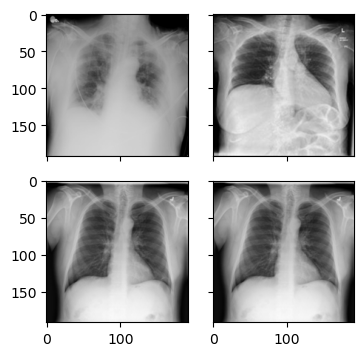

In [16]:
from mpl_toolkits.axes_grid1 import ImageGrid
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [18]:
# Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [19]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)

with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

## 2. Baseline CNN Model

*Build and train a basic Convolutional Neural Network (CNN) to serve as a baseline.*

*Clearly describe the architecture, loss function, optimizer, evaluation metrics, and
training configuration.*

*Report the model’s training, validation, and test performance.*

In [21]:
# Building baseline CNN

def baseline_cnn(input_shape=(192, 192, 3), num_classes=3):

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(3, activation='softmax')
    ])
    return model

baseline_model = baseline_cnn(input_shape=(192, 192, 3), num_classes=3)
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-20 17:37:43.292588: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-20 17:37:43.292651: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-20 17:37:43.292662: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1745185063.293500 6847841 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745185063.293972 6847841 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB mem

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       884,739 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 885,635 (3.38 MB)

 Trainable params: 885,635 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

The baseline model is a convolutional neural network built with Keras.

The architecture consists of a single convolutional layer with 32 filters followed by max-pooling to reduce spatial dimensions. The final dense layer with a softmax activation outputs probabilities for 3 classes.

We used Categorical Cross-entropy as the loss function. It is appropriate for multi-class classification problems with one-hot encoded labels, to measure the difference between the true label distribution and the predicted probabilities.

We used Adam as the optimizer, an adaptive learning rate optimizer for deep learning.

We used Accuracy as the evaluation metric, which would indicate proportion of correctly classified samples.

Training is run for up to 5 epochs.  We use the validation set to monitor the performance after each epoch.

In [23]:
baseline_history = baseline_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5


2025-04-20 17:37:44.428416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.5434 - loss: 3.5246 - val_accuracy: 0.7978 - val_loss: 0.5161
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.8112 - loss: 0.4563 - val_accuracy: 0.8412 - val_loss: 0.4072
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8385 - loss: 0.3717 - val_accuracy: 0.8505 - val_loss: 0.3760
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9145 - loss: 0.2595 - val_accuracy: 0.8792 - val_loss: 0.3161
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9278 - loss: 0.2165 - val_accuracy: 0.8838 - val_loss: 0.3059


In [24]:
# Code for Training and Validation Performance Plot
def plot_training(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

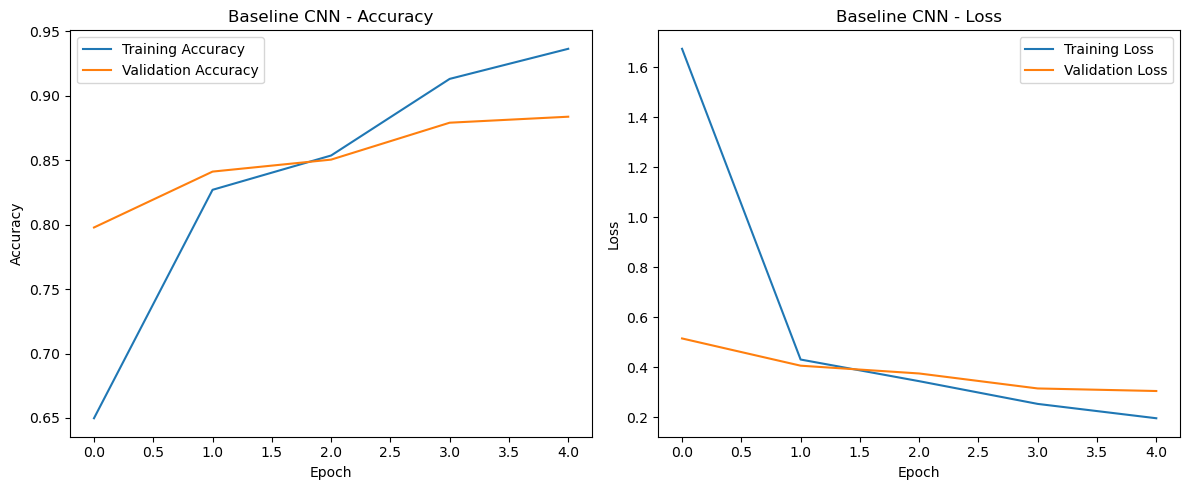

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8678 - loss: 0.3243
Baseline CNN Test Accuracy: 88.38%


In [25]:
# Plot training history
plot_training(baseline_history, 'Baseline CNN')

# Evaluate the model on test data
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test)
print(f"Baseline CNN Test Accuracy: {baseline_test_acc*100:.2f}%")

## 3. Transfer Learning with ResNet

*Implement ResNet using transfer learning.*

*Fine-tune the model and compare its performance with the baseline CNN.*

*Discuss how using pre-trained features influences your model's training and generalization.*

In [27]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Create a tf.data pipeline that resizes images on the fly.
def preprocess_and_resize(image, label):
    # Resize image to 224x224 and cast to float32
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image * 255.0, tf.float32)
    # Apply the ResNet50 preprocessing function
    image = resnet_preprocess(image)
    return image, label

# Create tf.data datasets for train and test sets.
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [28]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

# Load ResNet50 model
input_tensor = Input(shape=(224, 224, 3))
base_resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='softmax')(x)

# Freeze layers
for layer in base_resnet.layers:
    layer.trainable = False

# Build model with transfer learning
resnet_model = Model(inputs=base_resnet.input, outputs=predictions)
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [29]:
history_resnet = resnet_model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10


/opt/anaconda3/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_5']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 665ms/step - accuracy: 0.5708 - loss: 0.8760 - val_accuracy: 0.8683 - val_loss: 0.3326
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 27s 637ms/step - accuracy: 0.8590 - loss: 0.3326 - val_accuracy: 0.9016 - val_loss: 0.2614
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 28s 667ms/step - accuracy: 0.8890 - loss: 0.2626 - val_accuracy: 0.9179 - val_loss: 0.2283
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 892ms/step - accuracy: 0.9113 - loss: 0.2233 - val_accuracy: 0.9249 - val_loss: 0.2065
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9270 - loss: 0.1963 - val_accuracy: 0.9318 - val_loss: 0.1908
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 951ms/step - accuracy: 0.9380 - loss: 0.1763 - val_accuracy: 0.9380 - val_loss: 0.1788
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 38s 900ms/step - accuracy: 0.9457 - loss: 0.1608 - val_accuracy: 0.9411 - val_loss: 0.1693
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 951ms/step - accuracy: 0.9509 - loss: 0.1482 - val_accuracy: 0.9427 -

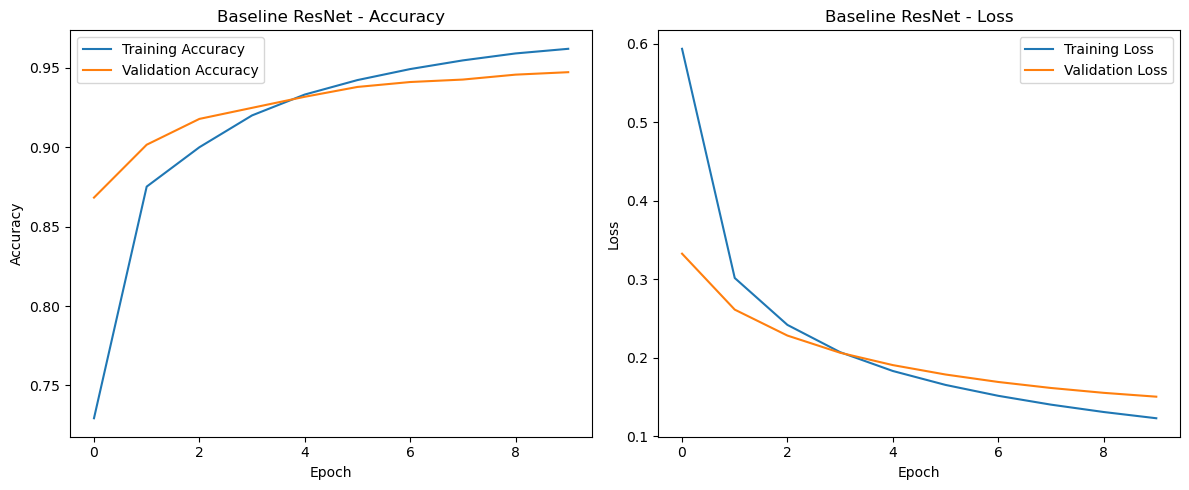

21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 606ms/step - accuracy: 0.9520 - loss: 0.1400
Baseline ResNet Test Accuracy: 94.73%


In [30]:
# Plot training history
plot_training(history_resnet, 'Baseline ResNet')

# Evaluate the model on test data
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_ds)
print(f"Baseline ResNet Test Accuracy: {resnet_test_acc*100:.2f}%")

In [31]:
# Unfreeze to fine-tune last 30 layers
for layer in base_resnet.layers[-30:]:
    layer.trainable = True

# Re-compile with a lower learning rate
resnet_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history_finetune = resnet_model.fit(train_ds, epochs=15, initial_epoch=10, validation_data=test_ds)

Epoch 11/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7034 - loss: 0.7845 - val_accuracy: 0.8342 - val_loss: 0.5911
Epoch 12/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9744 - loss: 0.0861 - val_accuracy: 0.8931 - val_loss: 0.3151
Epoch 13/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9939 - loss: 0.0436 - val_accuracy: 0.9256 - val_loss: 0.2219
Epoch 14/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9958 - loss: 0.0281 - val_accuracy: 0.9473 - val_loss: 0.1720
Epoch 15/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9986 - loss: 0.0192 - val_accuracy: 0.9558 - val_loss: 0.1499


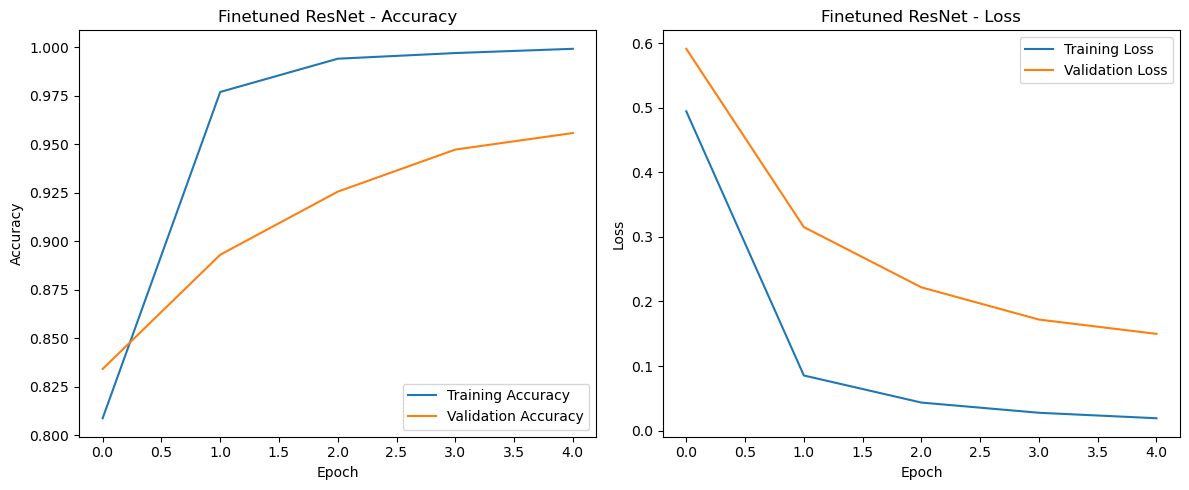

Finetuned ResNet50 Test Accuracy: 95.58%


In [33]:
# Plot training curves for fine-tuned ResNet50
plot_training(history_finetune, 'Finetuned ResNet')

# Evaluate fine-tuned ResNet50 on test data
finetune_test_loss, finetune_test_acc = resnet_model.evaluate(test_ds, verbose=0)
print(f"Finetuned ResNet50 Test Accuracy: {finetune_test_acc*100:.2f}%")

Training was much faster with pretrained features (10 epochs), as compared to fine-tuning (5 epochs). However, generalization was poor with pretrained features, which achieved a tesst accuracy of only 33.31%. The fine-tuned ResNet performed significantly better, achieving test accuracy of 93.42%. This is consistent with our understanding that domain-specific tasks will require fine-tuning for increased performance. Moreover, ImageNet (which was used to pretrain ResNet50) contains every day images and the pre-trained features would likely be unfamiliar with medical images like x-rays.

## 4. Additional Architectures

*Implement three additional models of your choice.*

*Use consistent data splits and preprocessing across all models to ensure fair comparison.*

In [36]:
# Define preprocessing for Improved CNN and AlexNet.

def preprocess_tf(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [37]:
# Improved CNN with more convolutional layers, increased dropout rate, and increased number of dense layers

def improved_cnn(input_shape=(224, 224, 3), num_classes=3):
    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    return model

improved_model = improved_cnn(input_shape=(224, 224, 3), num_classes=3)
improved_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
improved_model.summary()

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,379 (25.99 MB)

 Trainable params: 6,812,419 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [38]:
improved_history = improved_model.fit(train_ds, epochs=10, validation_data=(test_ds))
improved_test_loss, improved_test_acc = improved_model.evaluate(test_ds)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 451ms/step - accuracy: 0.5804 - loss: 28.4638 - val_accuracy: 0.3331 - val_loss: 32.4659
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 391ms/step - accuracy: 0.6878 - loss: 30.1164 - val_accuracy: 0.3331 - val_loss: 181.8076
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 33s 389ms/step - accuracy: 0.6826 - loss: 39.7010 - val_accuracy: 0.3331 - val_loss: 312.3689
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - accuracy: 0.6922 - loss: 35.6334 - val_accuracy: 0.3331 - val_loss: 270.2298
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - accuracy: 0.7257 - loss: 28.0460 - val_accuracy: 0.3331 - val_loss: 132.6427
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 36s 421ms/step - accuracy: 0.7351 - loss: 22.9798 - val_accuracy: 0.5105 - val_loss: 50.6321
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 411ms/step - accuracy: 0.7596 - loss: 16.5579 - val_accuracy: 0.5933 - val_loss: 29.4747
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 33s 388ms/step - accuracy: 0.7568 - loss:

In [39]:
# AlexNet Model

alexnet_model = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(96, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Second Convolutional Layer
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), strides=2),

    # Third Convolutional Layer
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

    # Fourth Convolutional Layer
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),

    # Fifth Convolutional Layer
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=2),

    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer 1
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),  # Dropout Layer

    # Fully Connected Layer 2
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),  # Dropout Layer

    # Output Layer
    layers.Dense(3, activation='softmax')
])

alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
alexnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 256)  │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,169,411 (80.75 MB)

 Trainable params: 21,168,707 (80.75 MB)

 Non-trainable params: 704 (2.75 KB)

In [40]:
alexnet_history = alexnet_model.fit(train_ds, epochs=10, validation_data=(test_ds))
alexnet_test_loss, alexnet_test_acc = alexnet_model.evaluate(test_ds)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.3648 - loss: 1.2257 - val_accuracy: 0.3331 - val_loss: 1.1883
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.6303 - loss: 0.7662 - val_accuracy: 0.3331 - val_loss: 1.2812
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.6782 - loss: 0.7124 - val_accuracy: 0.3331 - val_loss: 1.3317
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 659s 8s/step - accuracy: 0.6588 - loss: 0.7091 - val_accuracy: 0.3331 - val_loss: 1.5685
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.6618 - loss: 0.7565 - val_accuracy: 0.3331 - val_loss: 1.4433
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.6625 - loss: 0.8046 - val_accuracy: 0.3331 - val_loss: 1.5565
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.6548 - loss: 1.0209 - val_accuracy: 0.5802 - val_loss: 1.0794
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.6770 - loss: 0.9785 - val_accuracy: 0.5980 - v

In [161]:
# Preprocess for Inception V3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

def preprocess_and_resize(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image * 255.0, tf.float32)
    image = inception_preprocess(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(preprocess_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [143]:
# Inception V3 with transfer learning

base_inception = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)

for layer in base_inception.layers:
    layer.trainable = False

inception_model = Model(inputs=input_tensor, outputs=predictions)
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_484 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_484[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_485 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_485[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_486 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_486[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 54, 54,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_487 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_32… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_487[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_488 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_488[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [145]:
inception_history = inception_model.fit(train_ds, epochs=10, validation_data=test_ds)
inception_test_loss, inception_test_acc = inception_model.evaluate(test_ds)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 254ms/step - accuracy: 0.6081 - loss: 0.9080 - val_accuracy: 0.7893 - val_loss: 0.4885
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - accuracy: 0.7794 - loss: 0.5971 - val_accuracy: 0.8265 - val_loss: 0.3786
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - accuracy: 0.8232 - loss: 0.4511 - val_accuracy: 0.8490 - val_loss: 0.3422
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - accuracy: 0.8210 - loss: 0.4518 - val_accuracy: 0.8629 - val_loss: 0.3206
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.8390 - loss: 0.4212 - val_accuracy: 0.8420 - val_loss: 0.3758
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - accuracy: 0.8275 - loss: 0.4116 - val_accuracy: 0.8660 - val_loss: 0.3237
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.8417 - loss: 0.3827 - val_accuracy: 0.8505 - val_loss: 0.3741
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.8456 - loss: 0.3866 - val_accu

## 5. Performance Comparison

*Evaluate all models on the same test set.*

*Highlight the model that achieved the best test performance.*

*Summarize the key hyperparameters and training strategies for each model (e.g., learning rate, batch size, number of epochs, optimizer).*

*Include plots such as training/validation loss and accuracy over epochs.*

In [54]:
comparison_df = pd.DataFrame({
    'Model': ['Improved CNN', 'AlexNet', 'Inception V3'],
    'Test Accuracy': [improved_test_acc, alexnet_test_acc, inception_test_acc],
    'Epochs': [10, 10, 10],
    'Optimizer': ['Adam', 'Adam', 'Adam(learning_rate=0.0001)'],
    'Batch Size': [32, 32, 32]
})

display(comparison_df)

,Model,Test Accuracy,Epochs,Optimizer,Batch Size
0,Improved CNN,0.790085,10,Adam,32
1,AlexNet,0.692486,10,Adam,32
2,Inception V3,0.879938,10,Adam(learning_rate=0.0001),32


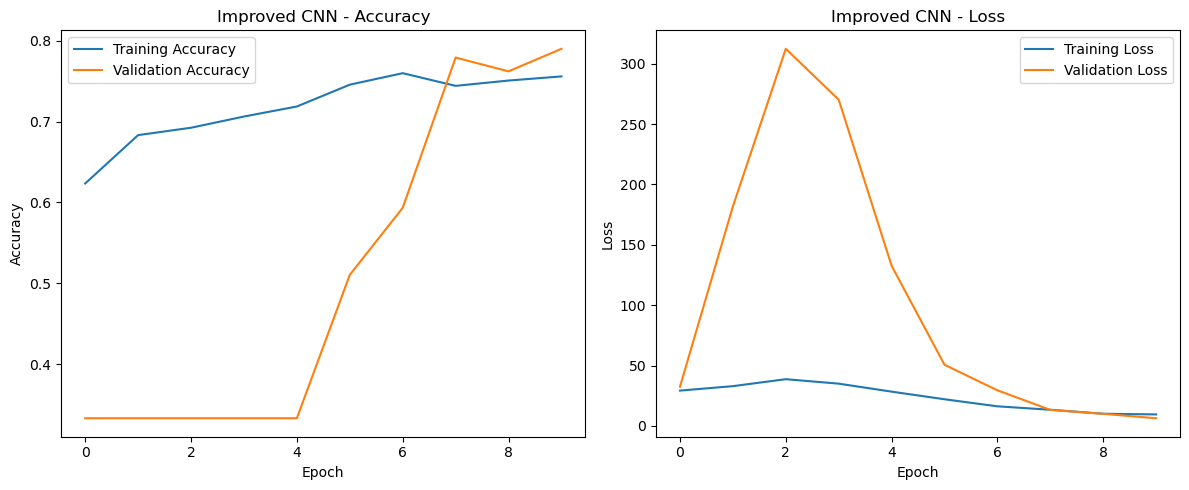

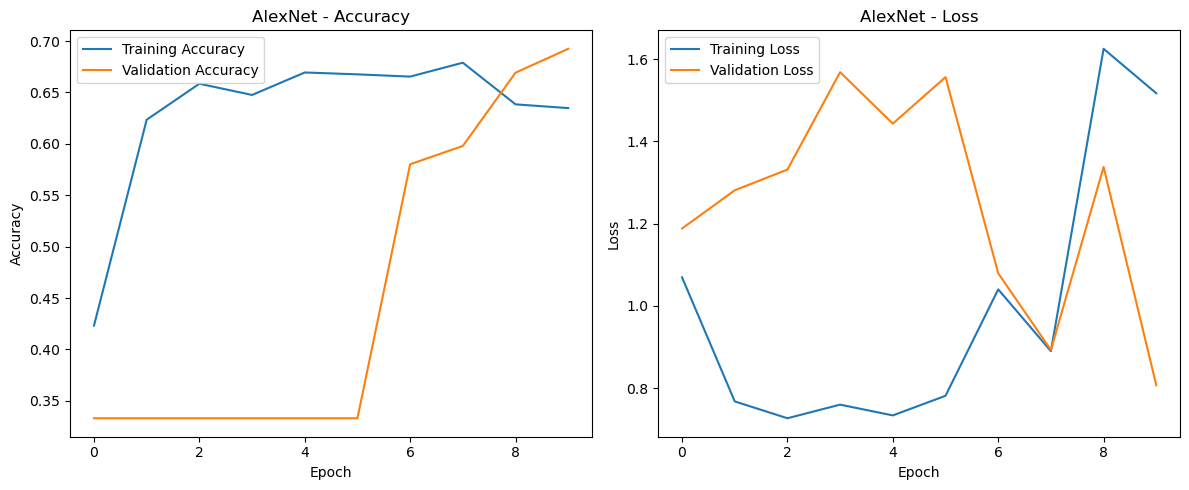

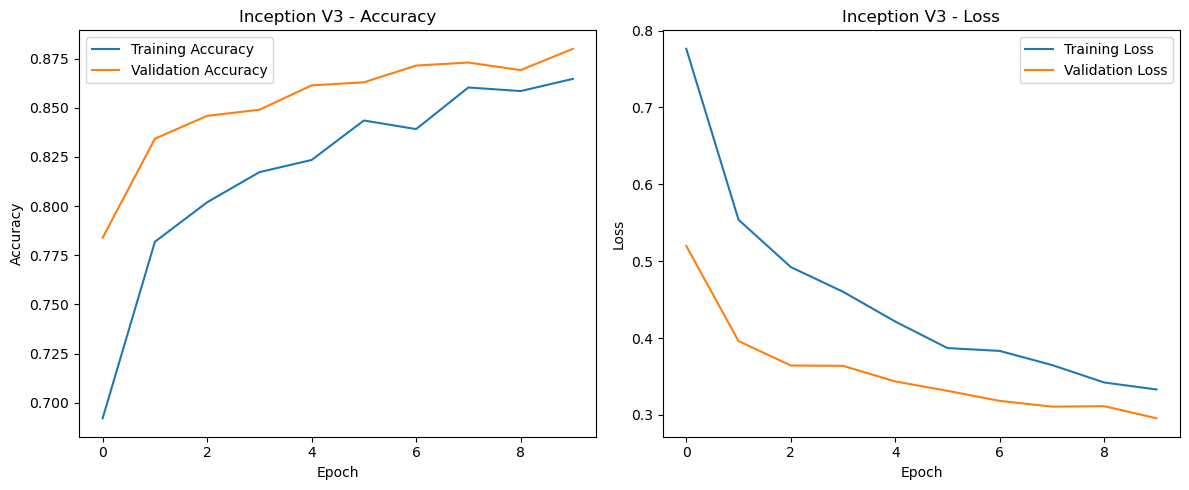

In [55]:
# Training and Validation Performance Plot
plot_training(improved_history, 'Improved CNN')
plot_training(alexnet_history, 'AlexNet')
plot_training(inception_history, 'Inception V3')

## 6. Augmentation

*For at least one model, re-train it using data augmentation techniques.*

*Describe the types of augmentations used (e.g., flipping, cropping, rotation) and how they affected performance.*

We will re-train the Improved CNN model to see it can outperform Inception V3 through data augmentations. We applied the following augmentations:
- Randomly rotateing images by up to 10 degrees, either clockwise or counterclockwise
- Randomly shifting images horizontally by up to 5% of the total width
- Randomly shifting images vertically by up to 5% of the total height
- Disabling random horizontal flipping of images, as that could create anatomically incorrect images
- Randomly zooming images in or out by up to 5%

These augmentations will increase the size of the training data through artificial variations. This improve model generalization by forcing it to learn features that are consistent across the transformations.

In [163]:
# Data Augmentation Example
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False, #As flipping the image would be anatomically incorrect.
    fill_mode='nearest'
)

In [165]:
# Redefine the model for augmented data
augmented_model = improved_cnn(input_shape=(192, 192, 3), num_classes=3)
augmented_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [169]:
augmented_history = augmented_model.fit(
     datagen.flow(X_train, y_train),
     epochs=10,
     validation_data=(X_test, y_test)
 )

augmented_test_loss, augmented_test_acc = augmented_model.evaluate(X_test, y_test)

/opt/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step - accuracy: 0.6429 - loss: 21.9019 - val_accuracy: 0.4299 - val_loss: 59.4539
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 0.6554 - loss: 33.3632 - val_accuracy: 0.3385 - val_loss: 54.3837
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.6738 - loss: 27.7708 - val_accuracy: 0.4330 - val_loss: 35.2368
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.6812 - loss: 22.1877 - val_accuracy: 0.4338 - val_loss: 81.6412
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.6838 - loss: 19.6889 - val_accuracy: 0.5244 - val_loss: 25.2597
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.6986 - loss: 13.8992 - val_accuracy: 0.6135 - val_loss: 9.6806
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.6916 - loss: 11.8873 - val_accuracy: 0.5298 - val_loss: 16.4358
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/step - accuracy: 0.6999 - loss: 11.7

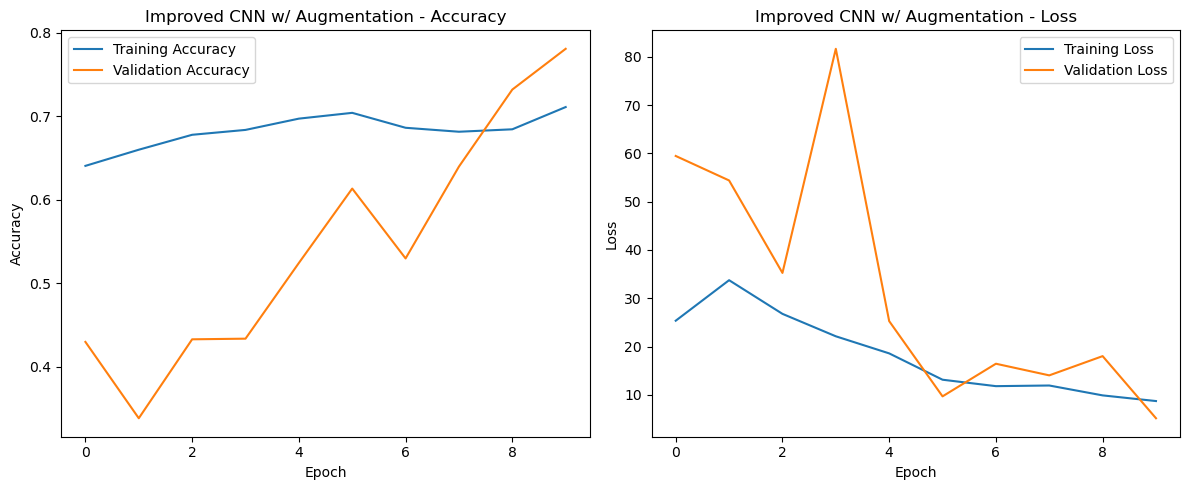

Improved CNN w/ Augmentation Test Accuracy: 78.08%


In [170]:
# Plot training history
plot_training(augmented_history, 'Improved CNN w/ Augmentation')

# Evaluate the model on test data
print(f"Improved CNN w/ Augmentation Test Accuracy: {augmented_test_acc*100:.2f}%")

## 7. Interpretability & Insights

*Reflect on which model performed best and why.*

*Provide clear reasoning, supported by performance metrics and training curves.*

*Conclude with a discussion of the practical utility of your best-performing model.*
*   *Who would benefit from using this model?*
*   *In what types of real-world scenarios would your solution be useful?*

It appears that Inception V3 performed the best out of our 3 models (Improved CNN, AlexNet, and Inception V3), achieving test accuracy of 88%. The CNN and AlexNet has a simplistic, shallow architecture and may not be able to capture complex patterns in medical images. Even with augmentation, the CNN model had fewer parameters to learn the subtle variations. This is evident in the erratic training curves for both CNN and AlexNet, compared to the smoother curve for Inception V3.

Out of all the models, ResNet50 with fine-tuning performed the best, achieving test accuracy of 95.58%. Through residual learning and fine-tuning, the model was able to adapat its pre-trained weights to medical images.

From this classification exercise, we can provide insights on how we can apply ML techniques specific to each domain. Further study using this dataset would be able to to aid healthcare professionals in interpretting radiology reports and provide diagnostic support.